## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.  
Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

### 1. [Откройте и изучите файл](#paragraph1)

### 2. [Разбейте данные на выборки](#paragraph2)

### 3. [Исследуйте модели](#paragraph3)


### 4. [Проверьте модель на тестовой выборке](#paragraph4)

### 5. [(бонус) Проверьте модели на адекватность](#paragraph5)

### 6. [Вывод](#paragraph6)

# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

<a name="paragraph1"></a>
## 1. Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.6 KB


Пропусков нет, все переменные количественные. Целевая переменная `is_ultra` принимает два значения. Это задача бинарной классификации. Построим гистограммы признаков

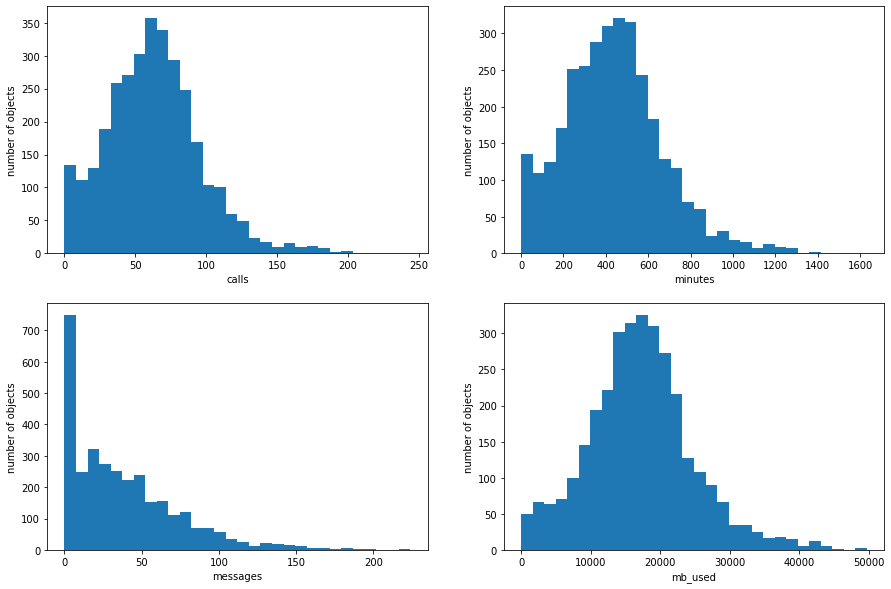

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
feature_columns = np.array(df.iloc[:,:4])

for i, axis in enumerate(axes.flat):
    axis.hist(feature_columns[:, i], bins=30)
    axis.set_xlabel(df.columns[i])
    axis.set_ylabel('number of objects')

In [5]:
def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
    """
    input: data - данные для построения гистограммы
           data_label - описание данных
           num_bins - количество ячеек
    output: None
    description: Функция строит гистограмму и boxplot для выбранного параметра:
                - Плотность распределения (методом distplot() библиотеки seaborn)
                - Boxplot (метод boxplot() библиотеки seaborn)
    """
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.distplot(data, bins=num_bins, rug=rug, ax=axes[0])
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=df, x=data_label, ax=axes[1])
    plt.show()

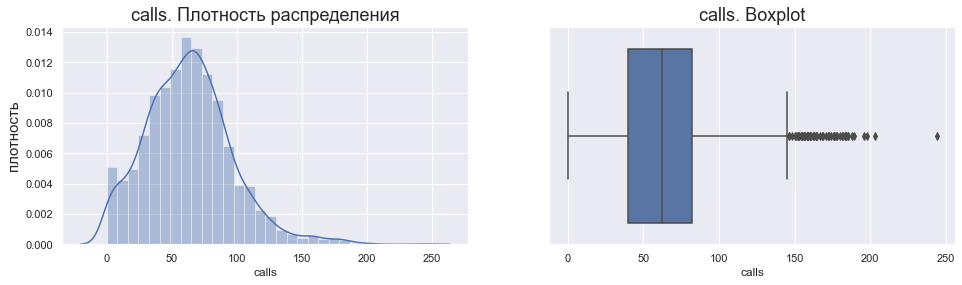

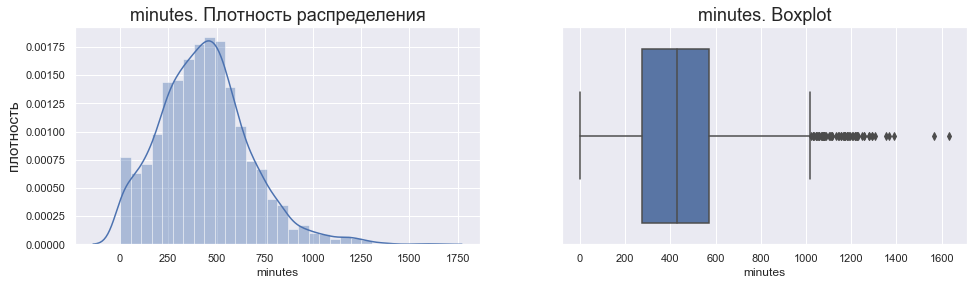

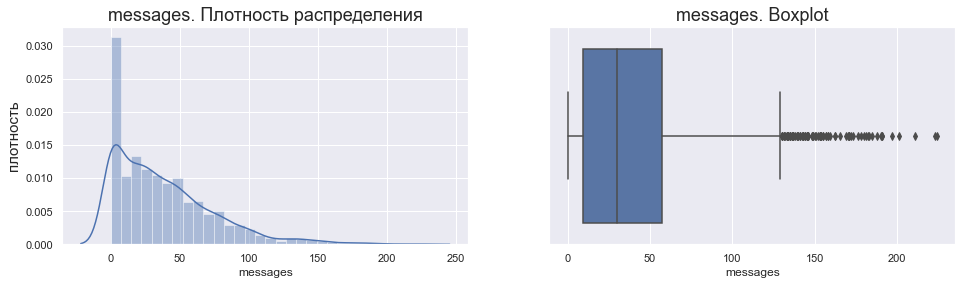

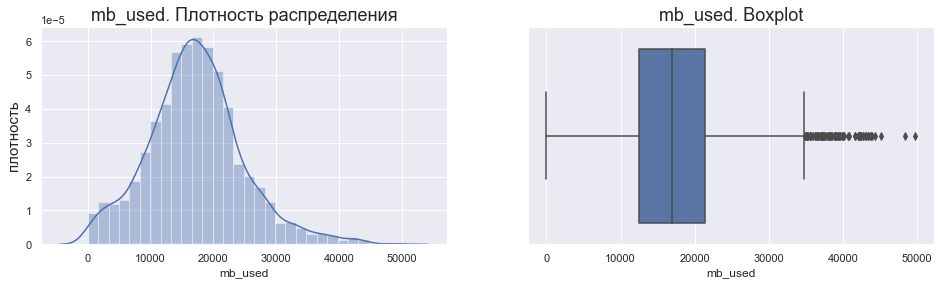

In [6]:
for column in df.drop('is_ultra', axis=1).columns:
    show_hists(df[column], column, num_bins=30)

В целом распределение кажется адекватным. Немного смущает пик около нуля у признака `messages`. 

In [7]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,calls,minutes,messages,mb_used,is_ultra
calls,1.00,0.98,0.18,0.29,0.21
minutes,0.98,1.00,0.17,0.28,0.21
messages,0.18,0.17,1.00,0.20,0.20
mb_used,0.29,0.28,0.20,1.00,0.20
is_ultra,0.21,0.21,0.20,0.20,1.00


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


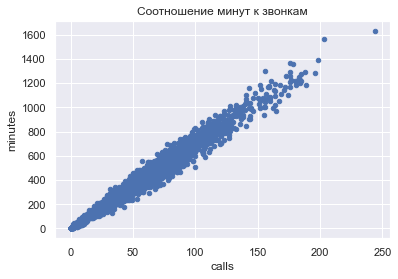

In [8]:
df.plot(kind='scatter', x='calls', y='minutes')
plt.title('Соотношение минут к звонкам')
plt.show()

Text(0.5, 1.08, 'Парные взаимосвязи между показателями')

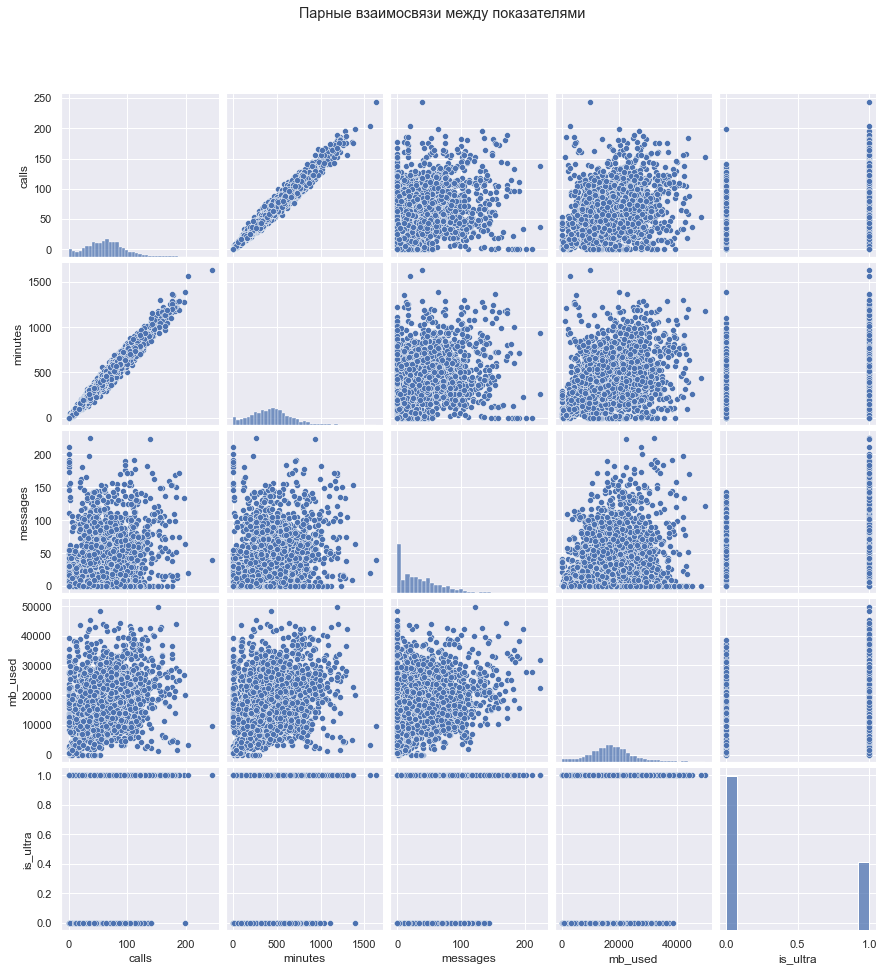

In [9]:
ax = sns.pairplot(df)
ax.fig.suptitle("Парные взаимосвязи между показателями", y=1.08)

*Расчет долей выбросов по всем параметрам*

In [10]:
def outliers_rate(data, column):
    """
    input: data - таблица данных
           column - признак для подсчета доли выбросов
    output: None
    description: Функция считает и выводит долю выбросов по выбранному признаку в %.
                 функция возвращает значение границы выбросов.
    """
    # квантили считаются методом quantile()
    # граница выбросов считается по формуле  [ q.75 + (q.75 - q.25)*1.5 ]
    max_val = (data[column].quantile(0.75) - data[column].quantile(0.25)) *1.5 + data[column].quantile(0.75)
    rate = round(len(data.loc[data[column] > max_val]) / len(data) * 100, 2)
    print('Доля выбросов в параметре {}: {} %'.format(column, rate))
    return max_val

In [11]:
# в переменной max_vals будем хранить границы выбросов по признакам
max_vals = []
# считаем границы выбросов по всем признакам и выводим доли выбросов по отдельным признакам
for column in df.drop('is_ultra', axis=1).columns:
    max_vals.append(outliers_rate(df, column))

# считаем общую долю выбросов по всем признакам.
whole_rate = len(df.loc[(df['calls'] > max_vals[0]) | 
                (df['minutes'] > max_vals[1]) | 
                (df['messages'] > max_vals[2]) | 
                (df['mb_used'] > max_vals[3]) 
                          ]) / len(df)
print('Общая доля выбросов: {} %'.format(round(whole_rate * 100, 2)))

Доля выбросов в параметре calls: 1.93 %
Доля выбросов в параметре minutes: 1.9 %
Доля выбросов в параметре messages: 2.83 %
Доля выбросов в параметре mb_used: 2.4 %
Общая доля выбросов: 6.47 %


<a name="paragraph2"></a>
## 2. Разбейте данные на выборки

Разобьем датасет на 3 части. 60% - обучающая выборка, 20% - валидационная, 20% - тестовая.

In [14]:
df_train, df_valid_test = train_test_split(df, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_valid_test, test_size=0.5, random_state=12345)

In [15]:
features_train = df_train.drop(['is_ultra'], axis = 1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis = 1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis = 1)
target_test = df_test['is_ultra']

<a name="paragraph3"></a>
## 3. Исследуйте модели

Для начала возьмем три модели без специального установления параметров и проверим их точность.

In [16]:
def models_accuracy(model, name):
    model = model(random_state=12345)
    model.fit(features_train, target_train)
    valid_answers = model.predict(features_valid)
    acccuracy = accuracy_score(target_valid, valid_answers)
    precision = precision_score(target_valid, valid_answers)
    recall = recall_score(target_valid, valid_answers)
    print(f' Модель {name}, accuracy: {acccuracy}, precision: {precision}, recall: {recall}')
    
models_accuracy(DecisionTreeClassifier, 'Дерево решений')
models_accuracy(RandomForestClassifier, 'Случайный лес')
models_accuracy(LogisticRegression, 'Логистическая регрессия')

 Модель Дерево решений, accuracy: 0.713841368584759, precision: 0.5135135135135135, recall: 0.5026455026455027
 Модель Случайный лес, accuracy: 0.7853810264385692, precision: 0.6808510638297872, recall: 0.5079365079365079
 Модель Логистическая регрессия, accuracy: 0.7107309486780715, precision: 0.5882352941176471, recall: 0.05291005291005291


Наиболее высокий accuracy у модели Случайный лес - 0.785

Теперь в цикле будем перебирать разные значения параметров, чтобы выявить те, которые дают наибольшую точность. Сделаем это поочередно для каждой из моделей.

In [19]:
lr_model = LogisticRegression(random_state=12345) 
lr_model.fit(features_train, target_train)
logistic_accuracy = lr_model.score(features_test, target_test)
print('Точность логистической регресии:', logistic_accuracy)

Точность логистической регресии: 0.6842923794712286


In [20]:
for depth in range(1, 20): 
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    predictions_train = model.predict(features_train)
    predictions_valid = model.predict(features_valid)
    predictions_test = model.predict(features_test)
    print("max_depth =", depth, ": ")
    print('accuracy на тренировочной выборке', accuracy_score(target_train, predictions_train))
    print('precision на тренировочной выборке', precision_score(target_train, predictions_train))
    print('recall на тренировочной выборке', recall_score(target_train, predictions_train))
    print()
    print('accuracy на валидационной выборке', accuracy_score(target_valid, predictions_valid))
    print('precision на валидационной выборке', precision_score(target_valid, predictions_valid))
    print('recall на валидационной выборке', recall_score(target_valid, predictions_valid))
    print()

max_depth = 1 : 
accuracy на тренировочной выборке 0.7577800829875518
precision на тренировочной выборке 0.828125
recall на тренировочной выборке 0.26812816188870153

accuracy на валидационной выборке 0.7542768273716952
precision на валидационной выборке 0.7066666666666667
recall на валидационной выборке 0.2804232804232804

max_depth = 2 : 
accuracy на тренировочной выборке 0.7878630705394191
precision на тренировочной выборке 0.8006535947712419
recall на тренировочной выборке 0.4131534569983137

accuracy на валидационной выборке 0.7822706065318819
precision на валидационной выборке 0.7207207207207207
recall на валидационной выборке 0.42328042328042326

max_depth = 3 : 
accuracy на тренировочной выборке 0.8075726141078838
precision на тренировочной выборке 0.8100558659217877
recall на тренировочной выборке 0.48903878583473864

accuracy на валидационной выборке 0.7853810264385692
precision на валидационной выборке 0.7217391304347827
recall на валидационной выборке 0.43915343915343913

m

Был проварьирован гиперпараметр **максимальной глубины от 1 до 20**, оптимальными метриками обладает модель с глубиной **9**, именно она принимается за удовлетворяющую техническому заданию. Меньше 9 имеется тенденция к недообучению, а более 9 начинает появляться переобучение модели

In [21]:
model_tree = DecisionTreeClassifier(max_depth=9, random_state=12345)
model_tree.fit(features_train, target_train)
predictions_tree_train = model_tree.predict(features_train)
predictions_tree_valid = model_tree.predict(features_valid)
predictions_tree_test = model_tree.predict(features_test)
print("max_depth = 9")
print('accuracy на тренировочной выборке', accuracy_score(target_train, predictions_tree_train))
print('precision на тренировочной выборке', precision_score(target_train, predictions_tree_train))
print('recall на тренировочной выборке', recall_score(target_train, predictions_tree_train))
print()
print('accuracy на валидационной выборке', accuracy_score(target_valid, predictions_tree_valid))
print('precision на валидационной выборке', precision_score(target_valid, predictions_tree_valid))
print('recall на валидационной выборке', recall_score(target_valid, predictions_tree_valid))

max_depth = 9
accuracy на тренировочной выборке 0.8812240663900415
precision на тренировочной выборке 0.9333333333333333
recall на тренировочной выборке 0.6610455311973018

accuracy на валидационной выборке 0.7822706065318819
precision на валидационной выборке 0.7168141592920354
recall на валидационной выборке 0.42857142857142855


Аналогично для модели **случайного леса** было проварьировано **число оценщиков от 1 до 10**, оптимальной признана модель с **9** оценщиками.

In [22]:
best_rand_model = None
best_rand_result = 0
for est in range(1, 51, 10):
    for depth in range(1, 10):
        model_rand = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model_rand.fit(features_train, target_train) 
        predictions_rand_train = model_rand.predict(features_train)
        predictions_rand_valid = model_rand.predict(features_valid)
        predictions_rand_test = model_rand.predict(features_test)
    
        result_rand_train = accuracy_score(target_train, predictions_rand_train)
        result_rand_valid = accuracy_score(target_valid, predictions_rand_valid)
        result_rand_test = accuracy_score(target_test, predictions_rand_test)
        if result_rand_valid > best_rand_result:
            best_rand_model = model_rand 
            best_train_acc = result_rand_train
            best_train_prec = precision_score(target_train, predictions_rand_train)
            best_train_recall = recall_score(target_train, predictions_rand_train)
            best_valid_acc = result_rand_valid 
            best_valid_prec = precision_score(target_valid, predictions_rand_valid)
            best_valid_recall = recall_score(target_valid, predictions_rand_valid)
            best_test_acc = result_rand_test
            best_test_prec = precision_score(target_test, predictions_rand_test)
            best_test_recall = recall_score(target_test, predictions_rand_test)
            best_est = est
            best_depth = depth
print('N_estimators лучшей модели:', best_est)
print('Максимальная глубина лучшей модели:', best_depth)
print("accuracy наилучшей модели на тренировочной выборке:", best_train_acc)
print('precision наилучшей модели на тренировочной выборке', best_train_prec)
print('recall наилучшей модели на тренировочной выборке', best_train_recall)
print()
print("accuracy  наилучшей модели на валидационной выборке:", best_valid_acc)
print('precision наилучшей модели на валидационной выборке:', best_valid_prec)
print('recall наилучшей модели на валидационной выборке:', best_valid_recall)
print()
print("accuracy  наилучшей модели на тестовой выборке:", best_test_acc)
print('precision наилучшей модели на тестовой выборке:', best_test_prec)
print('recall наилучшей модели на тестовой выборке:', best_test_recall)

N_estimators лучшей модели: 41
Максимальная глубина лучшей модели: 9
accuracy наилучшей модели на тренировочной выборке: 0.8843360995850622
precision наилучшей модели на тренировочной выборке 0.9868421052631579
recall наилучшей модели на тренировочной выборке 0.6323777403035413

accuracy  наилучшей модели на валидационной выборке: 0.7931570762052877
precision наилучшей модели на валидационной выборке: 0.7222222222222222
recall наилучшей модели на валидационной выборке: 0.48148148148148145

accuracy  наилучшей модели на тестовой выборке: 0.8087091757387247
precision наилучшей модели на тестовой выборке: 0.7777777777777778
recall наилучшей модели на тестовой выборке: 0.5517241379310345


In [23]:
model_log = LogisticRegression(random_state=1) 
model_log.fit(features_train, target_train) 

predictions_log_train = model_log.predict(features_train)
predictions_log_valid = model_log.predict(features_valid)
predictions_log_test = model_log.predict(features_test)

print('accuracy на тренировочной выборке', accuracy_score(target_train, predictions_log_train))
print('precision на тренировочной выборке', precision_score(target_train, predictions_log_train))
print('recall на тренировочной выборке', recall_score(target_train, predictions_log_train))
print()
print('accuracy на валидационной выборке', accuracy_score(target_valid, predictions_log_valid))
print('precision на валидационной выборке', precision_score(target_valid, predictions_log_valid))
print('recall на валидационной выборке', recall_score(target_valid, predictions_log_valid))

accuracy на тренировочной выборке 0.7131742738589212
precision на тренировочной выборке 0.7631578947368421
recall на тренировочной выборке 0.09780775716694773

accuracy на валидационной выборке 0.7107309486780715
precision на валидационной выборке 0.5882352941176471
recall на валидационной выборке 0.05291005291005291


Модель логистической регрессии имеет не самые хорошие метрики, и нет возможности что-то варьировать, поэтому данная модель не подойдет для нашей задачи (**точность менее 0.75**)

<a name="paragraph4"></a>
## 4. Проверьте модель на тестовой выборке

Проверим насколько точной окажется модель, которая показала наилучшую точность на проверочной выборке на тестовой выборке

**Second Style Predictions**

In [26]:
print('accuracy модели дерева решений на тестовой выборке', accuracy_score(target_test, predictions_tree_test))
print('precision модели дерева решений на тестовой выборке', precision_score(target_test, predictions_tree_test))
print('recall модели дерева решений на тестовой выборке', recall_score(target_test, predictions_tree_test))

accuracy модели дерева решений на тестовой выборке 0.7807153965785381
precision модели дерева решений на тестовой выборке 0.7246376811594203
recall модели дерева решений на тестовой выборке 0.49261083743842365


In [27]:
print('accuracy модели случайного леса на тестовой выборке', accuracy_score(target_test, predictions_rand_test))
print('precision модели случайного леса на тестовой выборке', precision_score(target_test, predictions_rand_test))
print('recall модели случайного леса на тестовой выборке', recall_score(target_test, predictions_rand_test))

accuracy модели случайного леса на тестовой выборке 0.8087091757387247
precision модели случайного леса на тестовой выборке 0.7777777777777778
recall модели случайного леса на тестовой выборке 0.5517241379310345


In [28]:
print('accuracy модели логистической регрессии на тестовой выборке', accuracy_score(target_test, predictions_log_test))
print('precision модели логистической регрессии на тестовой выборке', precision_score(target_test, predictions_log_test))
print('recall модели логистической регрессии на тестовой выборке', recall_score(target_test, predictions_log_test))

accuracy модели логистической регрессии на тестовой выборке 0.6842923794712286
precision модели логистической регрессии на тестовой выборке 0.5
recall модели логистической регрессии на тестовой выборке 0.03940886699507389


<a name="paragraph5"></a>
## 5. (бонус) Проверьте модели на адекватность

Для проверки модели на адекватность, посмотрим насколько ее точность отличается от точности случайной модели, которая случайным образом возращает 0 или 1.

In [31]:
df['is_ultra'].value_counts() / df.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

**Second Style Test**

In [32]:
dummy_model = DummyClassifier(random_state=42)
dummy_model.fit(features_train, target_train)
print('Accuracy простейшей модели на валидационной выборке равна {}.'
      .format(dummy_model.score(features_valid, target_valid)))

Accuracy простейшей модели на валидационной выборке равна 0.7060653188180405.


Получили точность 70.1%, а это значит, что наши лучшие модели предсказывают точнее и проходят проверку на адекватность.

Для оценки адеватности используется **F-мера** - среднее гармоническое между precision и recall. Если хотя бы один из параметров близок к нулю, то и F-мера стремится к 0. Если оба стремятся к 1, то F-мера тоже стремится к 1.

In [33]:
test_predictions = best_rand_model.predict(features_test)
f_score = f1_score(target_test, test_predictions)
print('F-мера =', f_score)

F-мера = 0.6455331412103746


<a name="paragraph6"></a>
### Вывод: 
В ходе исследования мы обучили и проверили точность трех моделей:
- Дерево решений
- Случайный лес
- Логистическая регрессия

Исходный датасет разбили на три части: обучающая, проверочная и тестовая выброки.
Наилучшей моделью оказался алгоритм Случайного леса с параметрами: **максимальная глубина - 7**, **количество деревьев - 50**. Его точность на тестовой выборке - **0.7909516380655226**. Была проведена проверка, насколько эта модель отличается от случайной модели. Модель прошла проверку на адекватность, так как у случайной модели точность - **0.49297971918876754**. 